In [1]:
from fastapi import FastAPI
import pandas as pd
import numpy as np

from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

In [4]:
aws = pd.read_csv("./../FANNG_stock_price_8_4_25/AMAZON_daily.csv")

In [5]:
aws.Date = pd.to_datetime(aws.Date)
aws.set_index('Date', inplace=True)

In [77]:
data = aws.filter(['Close'])


In [78]:
def create_lags(df, lag_days):
    for lag in range(1, lag_days + 1):
        df[f'lag_{lag}'] = df['Close'].shift(lag)
    return df

In [79]:
lag_days = 5
data = create_lags(data, lag_days)
data.dropna(inplace = True)

In [80]:
data.head()

,Close,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,
1997-05-22,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-23,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-27,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-05-28,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-05-29,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354


In [81]:
features = [f'lag_{i}' for i in range(1, lag_days + 1)]
X = data[features]
y = data['Close']

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=False, test_size=0.1
)

In [82]:
model_lgb = lgb.LGBMRegressor()
model_lgb.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6383, number of used features: 5
[LightGBM] [Info] Start training from score 30.296513


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [83]:
# Predict
y_pred = model_lgb.predict(X_test)
# Get the root mean squared error (RMSE)
rmse_lgb = np.sqrt(np.mean(((y_pred - y_test) ** 2)))
print(f"Test RMSE: {rmse_lgb:.4f}")

Test RMSE: 18.6196


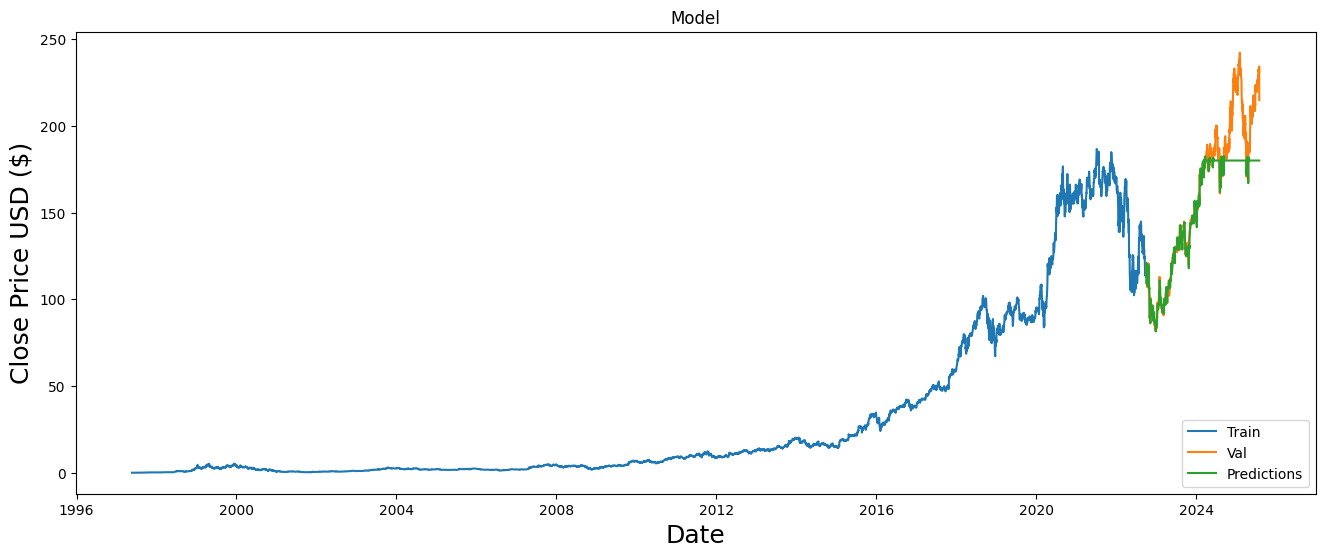

In [84]:
# Plot the data
train = data[:X_train.shape[0]]
valid = data[X_train.shape[0]:]
valid['Predictions'] = y_pred
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [85]:
valid.head()

,Close,lag_1,lag_2,lag_3,lag_4,lag_5,Predictions
Date,,,,,,,
2022-10-03,115.879997,113.000000,114.800003,118.010002,114.410004,115.150002,109.402823
2022-10-04,121.089996,115.879997,113.000000,114.800003,118.010002,114.410004,114.565443
2022-10-05,120.949997,121.089996,115.879997,113.000000,114.800003,118.010002,119.494340
2022-10-06,120.300003,120.949997,121.089996,115.879997,113.000000,114.800003,120.921763
2022-10-07,114.559998,120.300003,120.949997,121.089996,115.879997,113.000000,119.674999


In [23]:
X_test.shape

(704, 60)

In [24]:
y_test

Date
2022-10-11    112.209999
2022-10-12    112.900002
2022-10-13    112.529999
2022-10-14    106.900002
2022-10-17    113.790001
                 ...    
2025-07-28    232.789993
2025-07-29    231.009995
2025-07-30    230.190002
2025-07-31    234.110001
2025-08-01    214.750000
Name: Close, Length: 704, dtype: float64

In [67]:
valid[['Close', 'Predictions']]

,Close,Predictions
Date,,
2022-10-03,115.879997,109.402823
2022-10-04,121.089996,114.565443
2022-10-05,120.949997,119.494340
2022-10-06,120.300003,120.921763
2022-10-07,114.559998,119.674999
...,...,...
2025-07-28,232.789993,179.943768
2025-07-29,231.009995,179.943768
2025-07-30,230.190002,179.943768


In [26]:
valid = data[X_train.shape[0]:]

In [27]:
valid.shape

(704, 61)

In [28]:
valid.head()

,Close,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_51,lag_52,lag_53,lag_54,lag_55,lag_56,lag_57,lag_58,lag_59,lag_60
Date,,,,,,,,,,,,,,,,,,,,,
2022-10-11,112.209999,113.669998,114.559998,120.300003,120.949997,121.089996,115.879997,113.000000,114.800003,118.010002,...,134.949997,122.279999,120.970001,114.809998,121.139999,122.419998,124.629997,122.769997,118.209999,113.760002
2022-10-12,112.900002,112.209999,113.669998,114.559998,120.300003,120.949997,121.089996,115.879997,113.000000,114.800003,...,135.389999,134.949997,122.279999,120.970001,114.809998,121.139999,122.419998,124.629997,122.769997,118.209999
2022-10-13,112.529999,112.900002,112.209999,113.669998,114.559998,120.300003,120.949997,121.089996,115.879997,113.000000,...,134.160004,135.389999,134.949997,122.279999,120.970001,114.809998,121.139999,122.419998,124.629997,122.769997
2022-10-14,106.900002,112.529999,112.900002,112.209999,113.669998,114.559998,120.300003,120.949997,121.089996,115.879997,...,139.520004,134.160004,135.389999,134.949997,122.279999,120.970001,114.809998,121.139999,122.419998,124.629997
2022-10-17,113.790001,106.900002,112.529999,112.900002,112.209999,113.669998,114.559998,120.300003,120.949997,121.089996,...,142.570007,139.520004,134.160004,135.389999,134.949997,122.279999,120.970001,114.809998,121.139999,122.419998


In [30]:
y_test.describe()

count    704.000000
mean     160.325284
std       43.621112
min       81.820000
25%      125.980003
50%      171.195000
75%      192.577499
max      242.059998
Name: Close, dtype: float64

In [31]:
valid['Predictions'] = y_test

In [32]:
valid[['Close','Predictions']]

,Close,Predictions
Date,,
2022-10-11,112.209999,112.209999
2022-10-12,112.900002,112.900002
2022-10-13,112.529999,112.529999
2022-10-14,106.900002,106.900002
2022-10-17,113.790001,113.790001
...,...,...
2025-07-28,232.789993,232.789993
2025-07-29,231.009995,231.009995
2025-07-30,230.190002,230.190002


In [38]:
valid = data[X_train.shape[0]:]
valid['Predictions'] = y_pred

In [39]:
valid[['Close','Predictions']]

,Close,Predictions
Date,,
2022-10-11,112.209999,115.572205
2022-10-12,112.900002,118.005874
2022-10-13,112.529999,118.917024
2022-10-14,106.900002,118.470388
2022-10-17,113.790001,110.839885
...,...,...
2025-07-28,232.789993,175.958776
2025-07-29,231.009995,175.958776
2025-07-30,230.190002,175.958776


In [40]:
y_pred

array([115.57220476, 118.00587393, 118.91702446, 118.47038834,
       110.83988515, 118.10082231, 120.53604172, 117.34618972,
       117.91683327, 118.93381187, 119.44977909, 121.89679294,
       117.90030878, 114.92097069, 111.74387078, 111.67261622,
       103.10121114,  98.89538434,  91.98442359,  93.65385802,
        91.87793541,  92.48128081,  88.06414812,  94.76085847,
       106.12896232, 100.43802401, 106.15978637, 101.09355342,
        97.83217326,  95.59797785,  92.86614783,  93.52205523,
        94.26063125,  93.23647837,  95.10342553,  94.09640017,
        97.061696  ,  97.85137443,  96.2091124 ,  92.11264992,
        90.32459631,  89.0645121 ,  91.06447412,  88.97477556,
        91.06138904,  93.37488546,  90.58878557,  89.99006525,
        88.80599065,  88.44693827,  87.01367377,  86.75153198,
        86.36033862,  84.90021647,  84.17497128,  82.58168874,
        84.99784827,  84.58092238,  83.9662844 ,  84.93364102,
        83.3610834 ,  84.2799767 ,  85.10539282,  88.68